# Chroma from Luma (CfL)

In [1]:
%matplotlib inline

import os
import tarfile

from multiprocessing import Pool

import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import kmeans
from scipy.ndimage  import imread
from scipy.misc  import imsave

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = np.int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [2]:
img_folder = "images/kodim/"
kodims = []
kodim_files = []
for file in sorted(os.listdir(img_folder)):
    if file.endswith(".png"):
        kodim_files.append(file)
        kodims.append(imread(os.path.join(img_folder, file), mode="YCbCr"))
num_kodim = len(kodims)
        
def psnr(im1, im2):
    h, w = im1.shape
    sse = np.sum((im1 - im2)**2)
    return 20 * np.log10(255) - 10 * np.log10(sse/(h*w))

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggle').attr('value', 'Show code')  
 } else {
 $('div.input').show();
 $('#toggle').attr('value', 'Hide code') 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggle" value="Show code"></form>''')

In [4]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
block_size = 8

## Introduction

Chroma from Luma (CfL) is a coding tool that predicts information in the chromatic planes based on previously encoded information in the luma plane. The underlying assumption is that a local correlation exists between the luma plane and its chromatic counterparts. This correlation can be seen in the following image, notice the resemblance between the chromatic planes (Cr and Cr) and the luma plane.

Note: _A presentation was made from the work in this notebook, the latest version can be downloaded from_ https://gitlab.com/luctrudeau/CfL-AV1-Presentation/builds/artifacts/master/file/cfl-av1-presentation.pdf?job=build


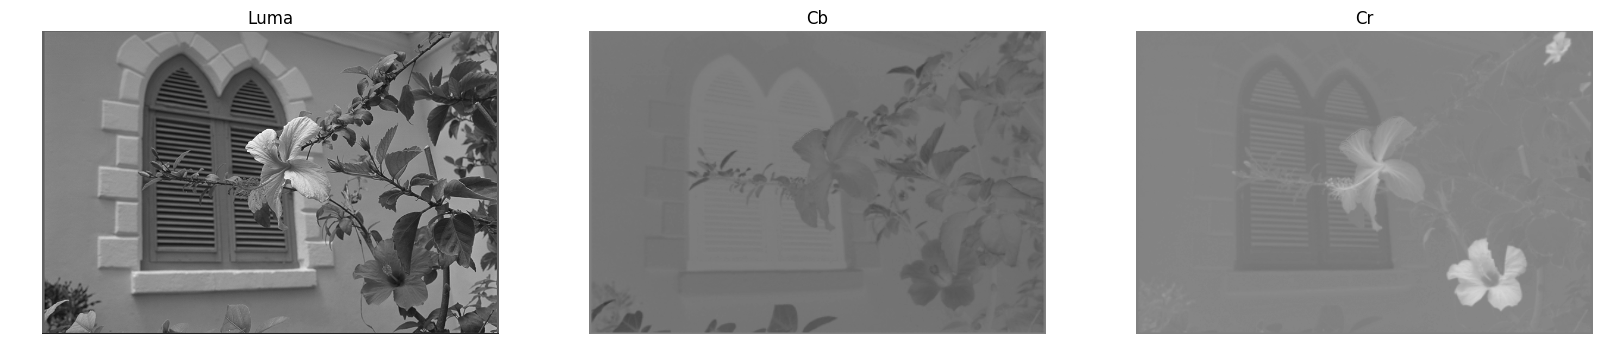

In [69]:
def showPlanes(im):
    plt.figure(figsize=(20,15))
    plt.subplot(1,3,1)
    showImage(im[:,:,0], "Luma")
    plt.subplot(1,3,2)
    showImage(im[:,:,1], "Cb")
    plt.subplot(1,3,3)
    showImage(im[:,:,2], "Cr")

def showImage(im, title):
    plt.imshow(im, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
    plt.axis('off')
    plt.title(title)
    
randIm = kodims[6] # kodims[int(np.round(np.random.rand()*len(kodims)))]
showPlanes(randIm);

In this document, we present the proposed CfL approach for the AV1 Codec. This new version of CfL draws from the strengths of the CfL implementation of the Thor codec and the CfL implementation of the Daala codec. 

In [[1]](https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02), Midtskogen proposes to compute $\alpha$ and $\beta$ using the predicted values of luma and chroma. These values are available in both the encoder and decoder. As such, they are not signaled in the bitstream. Additionally, Midtskogen uses a threshold of 64 on the mean squared error between the reconstructed luma pixel and the predicted luma pixel to decide whether or not CfL should be used. An important note about the work of Midtskogen is that it applies to intra frame coding and inter frame coding.

In [[2]](https://people.xiph.org/~unlord/spie_cfl.pdf), Egge and Valin propose a frequency domain version of CfL. the authors exploit the gain-shape coding nature of perceptual vector quantization (PVQ) to avoid having to perform model fitting to find $\alpha$ and $\beta$. As such, only a sign bit needs to be signaled. It is important to note that this version of CfL only predicts ACs coefficients.

The proposed solution is similar to [1] in that it is performed in the spatial domain and least squares is used. However, it differs from [1] in that $\alpha$ is signaled in the bitstream. As for $\beta$, Midtskogen computes it using the least squares equation, we propose to use DC_PRED as the value of $\beta$. This aligns with [2], in that CfL does not predict the DC.

The characteristics of the different CfL implementations are described in the following table.

|                                | Thor[1]    | Daala[2]  | Proposed |
|--------------------------------|------------|-----------|----------|
| Prediction Domain              | Spatial    | Frequency | Spatial  |
| Bitstream Signaling            | None       | Sign bit  | Alpha    |
| Encoder model fitting          | Yes        | Via PVQ   | Yes      |
| Decoder model fitting          | Yes        | No        | No       |
| Luma values used for fit       | Predicted  | Luma      | Luma     |
| Chroma values used for fit     | Predicted  | Chroma    | Chroma   |


## CfL Fundamentals

Although it does not always hold, the assumption of a linear relationship between the luma plane and its chromatic counterparts is not far-fetched. For example, the following image shows the relationship between the Luma and Chroma for an $8 \times 8$ block in the previous image.

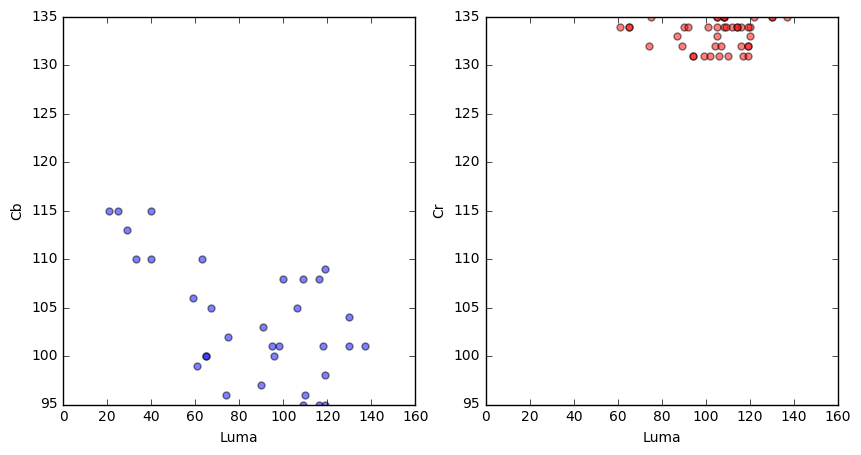

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(randIm[300:308,500:508,0].ravel(), randIm[300:308,500:508,1].ravel(), c="blue", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cb")
plt.gca().set_ylim([95, 135])
plt.subplot(1,2,2)
plt.scatter(randIm[300:308,500:508,0].ravel(), randIm[300:308,500:508,2].ravel(), c="red", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cr")
plt.gca().set_ylim([95, 135]);

Assuming that this relationship also exists between the $i$th reconstructed Luma pixel $\hat{L}_i$ and $i$th Chroma pixel $C_i$, 
a chromatic prediction of $C_i$ can be computed using the following equation

$$C'_i = \alpha \times \hat{L}_i + \beta,$$

where $\alpha$ is the slope and $\beta$ is y intercept. For a block of $N$ pixels, $\alpha$ and $\beta$ are computed with the least squares equations as follows

$$\alpha = \frac{N \sum_i \hat{L}_i C_i - \sum_i \hat{L}_i \sum_i C_i}{N \sum_i L_i^2 - (\sum \hat{L}_i)^2},$$

$$\beta = \frac{\sum_i C_i - \alpha \sum_i \hat{L}_i}{N}.$$

As explained in [1], signaling $\alpha$ and $\beta$ on a per block basis is too expensive. To avoid signaling these parameters, Midtskogen proposes instead to compute $\alpha'$ and $\beta'$ by replacing the actual values $\hat{L}$ and $C$ by their predicted counterparts $L'$ and $C'$.

The advantage of such an approach is that $L'$ and $C'$ are available to both the encoder and decoder, the model fitting is performed during encoding and during decoding, thus signaling alpha and beta is avoided. The disadvantage of this approach is that the model will fit the prediction but not the actual data. In the context of intra coding, the prediction might significantly differ from the actual values. This loss of precision will increase distortion and rate.

Fitting the model on the real values of $\hat{L}$ and $C$ generates a more precise model. However, this information is not available to the decoder and must be signaled in the bitstream. In this proposal, we will present different techniques to reduce the rate required to signal the model fitting parameters.

Let $\bar{L}$ be the subtraction of $\hat{L}$ by its average for a given block. Notice that $\bar{L}$ is zero mean, it follows that

$$\sum_i \bar{L_i} = 0.$$

Notice that when we replace $\hat{L}$ with $\bar{L}$ in the equation of $\beta$, we get the average chromatic pixel value. It just so happens that the intra prediction mode DC_PRED is designed to predict the average pixel value.

Next, let $\bar{C'}$ be the subtraction of $C$ by the predicted average using DC_PRED.

Replacing $\hat{L}$ by $\bar{L}$ and $C$ with $\bar{C'}$ in the equations of $\alpha$ and $\beta$ yields

$$\bar{\alpha} = \frac{\sum_i \bar{L}_i \bar{C'}_i}{\sum_i \bar{L}_i^2},$$

$$\bar{\beta} = \frac{\sum_i \bar{C'}_i}{N}.$$

Notice that $\bar{\beta}$ is the average of the residual of the chromatic block.

Based on the assumption that $\bar{\beta} \approx 0$, we predict chroma as follows

$$ C''_i = \bar{\alpha} \times \bar{L_i} + DC\_PRED $$

_Note that it could also be possible to signal $\sum_i \bar{L_i} \bar{C'_i}$ instead of $\alpha$. However, signaling $\alpha$ give better results._

### Symbolic version of the fundamentals

In this section, we show that the equation for $\bar{\alpha}$ from the previous section is optimal given that the error metric is the sum of squares between the CfL prediction and chroma block and that no $\beta$ is used.

First, let's exand the sum of squares between the CfL prediction and the chroma block

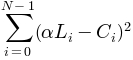

In [8]:
from sympy import diff, symbols, init_printing, solveset, Sum, IndexedBase, Eq, expand, factor
init_printing()

i, a, N = symbols('i, alpha N')
L = IndexedBase('L')
C = IndexedBase('C')

e = Sum((L[i]*a-C[i])**2, (i,0,N-1))
e

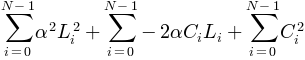

In [9]:
e2 = e.expand()
e2

Next, we take the derivative with respect to x and factorize each term

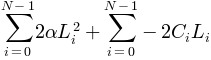

In [10]:
d = diff(e2,a)
d

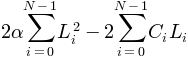

In [11]:
f = factor(Sum(2*a*L[i]**2, (i, 0, N - 1))) + factor(Sum(-2*C[i]*L[i], (i, 0, N - 1)))
f

Finally, to find the extremums, we solve for x, when the previous equation = 0

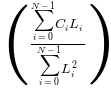

In [12]:
solveset(Eq(f,0),a)

This matches what we obtained for $\bar{\alpha}$ in the previous section. The difference is that, in the previous section we changed $L$ to be zero mean, whereas in this section we removed $\beta$ completely. In both cases, we get the same equation.

In other words, using a zero mean $L$ gives the optimal $\alpha$ given that no $\beta$ is used.

**TODO**: Find a way to take into consideration rounding when SSE is computed (deriving round() is a pain) 

In [13]:
from pywt import wavedec2

def gen_data(im, plane):
    height, width, z = im.shape
    block_size = 4
    inputs = []
    outputs = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bC = im[y:y+block_size, x:x+block_size, plane]
            
            L = wavedec2(bY, 'haar')
            C = wavedec2(bC, 'haar')
            
            inputs.append(np.concatenate([c.ravel() for p in L for c in p] + [c.ravel() for p in C[:-1] for c in p]))
            outputs.append(np.concatenate([c.ravel() for p in C[-1:] for c in p]))
    return (np.array(inputs), np.array(outputs))

inp_cb, out_cb, inp_cr, out_cr = [],[],[],[]
for kodim in log_progress(kodims):
    inp, out = gen_data(kodim, 1)
    inp_cb.append(inp)
    out_cb.append(out)
    inp, out = gen_data(kodim, 2)
    inp_cr.append(inp)
    out_cr.append(out)
inp_cb, out_cb, inp_cr, out_cr = np.vstack(inp_cb), np.vstack(out_cb), np.vstack(inp_cr), np.vstack(out_cr)

In [14]:
def cfl(im, plane):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    block_size = 2
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bC = im[y:y+block_size, x:x+block_size, plane]
            cfl[y:y+block_size, x:x+block_size] = np.round(np.mean(bC))
    return cfl

def cfl_psnr(im):
    psnr_cb = psnr(im[:, :, 1], cfl(im, 1))
    psnr_cr = psnr(im[:, :, 2], cfl(im, 2))
    return psnr_cb, psnr_cr

In [ ]:
from sklearn import neural_network

mlp_cb = neural_network.MLPRegressor(hidden_layer_sizes=(12,), activation='identity')
mlp_cb.fit(inp_cb, out_cb)

mlp_cr = neural_network.MLPRegressor(hidden_layer_sizes=(12,), activation='identity')
mlp_cr.fit(inp_cr, out_cr)

from pywt import waverec2

def cfl_prop(im, plane):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    block_size = 4
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bC = im[y:y+block_size, x:x+block_size, plane]
            L = wavedec2(bY, 'haar')
            C = wavedec2(bC, 'haar')
            inp = [np.concatenate([c.ravel() for p in L for c in p] + [c.ravel() for p in C[:-1] for c in p])]
            out = [mlp_cb, mlp_cr][plane - 1].predict(inp)
            C[-1] = (out[0][:4].reshape((2,2)), out[0][4:8].reshape((2,2)), out[0][8:].reshape((2,2)))
            cfl[y:y+block_size, x:x+block_size] = np.round(waverec2(C, 'haar'))
    return cfl

def cfl_prop_psnr(im):
    psnr_cb = psnr(im[:, :, 1], cfl_prop(im, 1))
    psnr_cr = psnr(im[:, :, 2], cfl_prop(im, 2))
    return psnr_cb, psnr_cr

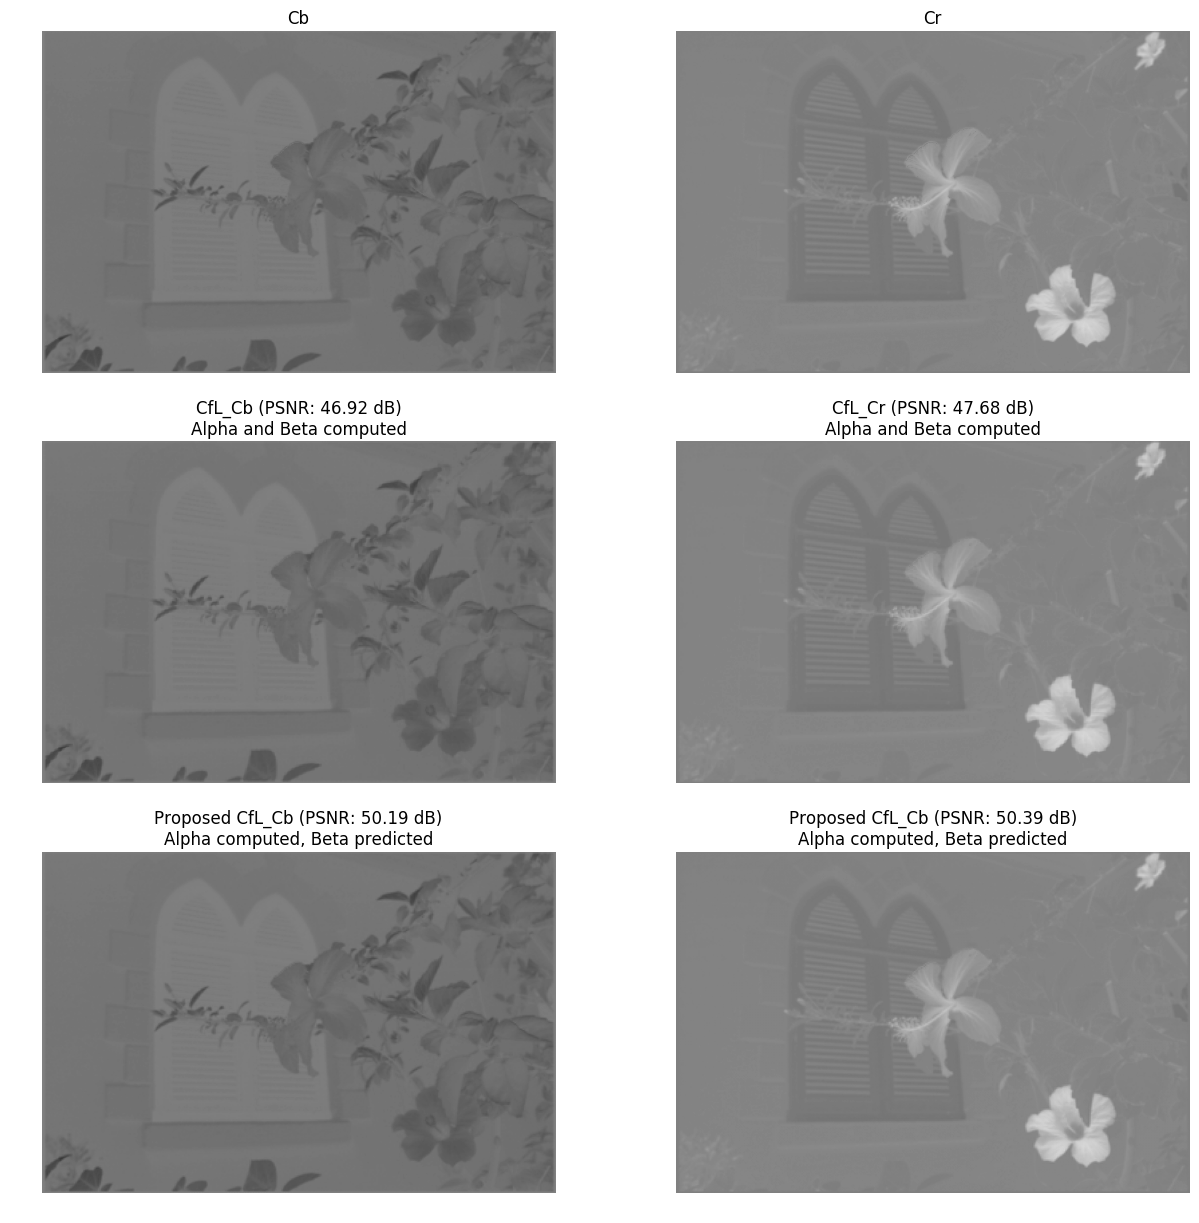

In [71]:
cfl_prob_cb = cfl_prop(randIm, 1)
cfl_prob_cr = cfl_prop(randIm, 2)

cfl_cb = cfl(randIm, 1)
cfl_cr = cfl(randIm, 2)
    
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
showImage(randIm[:,:,1], "Cb")
plt.subplot(3,2,2)
showImage(randIm[:,:,2], "Cr")
plt.subplot(3,2,3)
showImage(cfl_cb, "CfL_Cb (PSNR: %0.2f dB)\nAlpha and Beta computed" % psnr(randIm[:,:,1], cfl_cb))
plt.subplot(3,2,4)
showImage(cfl_cr, "CfL_Cr (PSNR: %0.2f dB)\nAlpha and Beta computed" % psnr(randIm[:,:,2], cfl_cr))
plt.subplot(3,2,5)
showImage(cfl_prob_cb, "Proposed CfL_Cb (PSNR: %0.2f dB)\nAlpha computed, Beta predicted" % psnr(randIm[:,:,1], cfl_prob_cb))
plt.subplot(3,2,6)
showImage(cfl_prob_cr, "Proposed CfL_Cb (PSNR: %0.2f dB)\nAlpha computed, Beta predicted" % psnr(randIm[:,:,2], cfl_prob_cr))

For a more general overview of the precision of the proposed approach, the following table shows the quality loss of the proposed CfL scheme on the images of the [Kodak Lossless True Color Image Suite](http://r0k.us/graphics/kodak/index.html)

In [55]:
table = ListTable()
table.append(['File name', 'PSNR CfL Cb', 'PSNR CfL Proposed Cb', 'PSNR CfL Cb', 'PSNR CfL Proposed Cr'])

psnr_cfl_cb = np.zeros((24,1))
psnr_cfl_prop_cb = np.zeros((24,1))
psnr_cfl_cr = np.zeros((24,1))
psnr_cfl_prop_cr = np.zeros((24,1))

with Pool() as pool:
    results = pool.map(cfl_psnr, kodims)
    results_prop = pool.map(cfl_prop_psnr, kodims)

for k in range(0,num_kodim):
    psnr_cb, psnr_cr = results[k]
    psnr_prop_cb, psnr_prop_cr = results_prop[k]
    psnr_cfl_cb[k] = round(psnr_cb, 2)
    psnr_cfl_prop_cb[k] = round(psnr_prop_cb, 2)
    psnr_cfl_cr[k] = round(psnr_cr, 2)
    psnr_cfl_prop_cr[k] = round(psnr_prop_cr, 2)
    table.append([kodim_files[k], str(psnr_cfl_cb[k]), str(psnr_cfl_prop_cb[k]), str(psnr_cfl_cr[k]), str(psnr_cfl_prop_cr[k])])

mean_psnr_cfl_prob_cb = round(np.mean(psnr_cfl_prop_cb),2)
mean_psnr_cfl_prob_cr = round(np.mean(psnr_cfl_prop_cr),2)
table.append(['Average', round(np.mean(psnr_cfl_cb),2), mean_psnr_cfl_prob_cb, round(np.mean(psnr_cfl_cr),2), mean_psnr_cfl_prob_cr])
table

File name,PSNR CfL Cb,PSNR CfL Proposed Cb,PSNR CfL Cb,PSNR CfL Proposed Cr
kodim01.png,[ 49.35],[ 50.9],[ 46.76],[ 49.32]
kodim02.png,[ 47.68],[ 50.17],[ 42.84],[ 45.65]
kodim03.png,[ 46.78],[ 49.09],[ 47.89],[ 49.72]
kodim04.png,[ 51.15],[ 52.43],[ 44.01],[ 46.76]
kodim05.png,[ 43.75],[ 46.58],[ 44.6],[ 47.72]
kodim06.png,[ 47.37],[ 48.89],[ 49.44],[ 50.43]
kodim07.png,[ 46.92],[ 50.19],[ 47.68],[ 50.39]
kodim08.png,[ 45.58],[ 47.31],[ 45.18],[ 46.99]
kodim09.png,[ 47.77],[ 49.69],[ 49.51],[ 51.04]
kodim10.png,[ 48.46],[ 49.48],[ 49.16],[ 50.64]


The PSNR reduction indicates the cost associated of assuming that $\bar{\beta} \approx 0$.

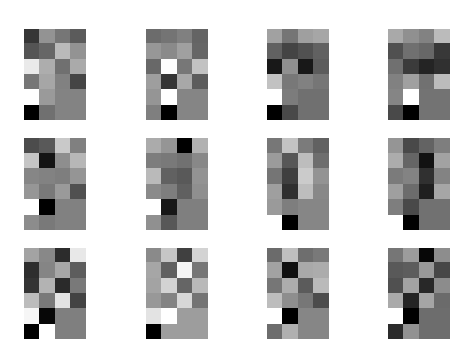

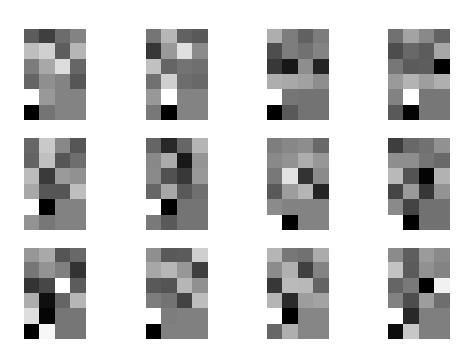

In [65]:
for mlp in [mlp_cb, mlp_cr]:
    fig, axes = plt.subplots(3, 4)
    for row, ax in zip(np.dot(*mlp.coefs_).T, axes.ravel()):
        invrow = waverec2(
            [row[:1].reshape((1,1)),
             (row[1:2].reshape((1,1)), row[2:3].reshape((1,1)), row[3:4].reshape((1,1))),
             (row[4:8].reshape((2,2)), row[8:12].reshape((2,2)), row[12:16].reshape((2,2)))],
            'haar')
        inv_uv = waverec2(
            [row[16:17].reshape((1,1)),
             (row[17:18].reshape((1,1)), row[18:19].reshape((1,1)), row[19:].reshape((1,1)))],
            'haar')
        ax.axis('off')
        ax.matshow(np.vstack((invrow/np.linalg.norm(invrow),np.hstack((inv_uv/np.linalg.norm(inv_uv),np.zeros((2,2)))))), cmap=plt.cm.gray)

## References
[1] Steinar Midtskogen,"Improved chroma prediction" IETF draft-midtskogen-netvc-chromapred-02 https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02 (October 2016)

[2] Nathan E. Egge and Jean-Marc Valin, "Predicting Chroma from Luma with Frequency Domain Intra Prediction", https://people.xiph.org/~unlord/spie_cfl.pdf (April 2016)